# Analysis with PHOEBE 

In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

logger = phoebe.logger('error')
#phoebe.mpi_off()

In [2]:
b = phoebe.default_binary()

b.set_value('ecc',0.022)
b.set_value('per0',30) #deg
b.set_value('teff@primary',7500) #K
b.set_value('teff@secondary',5000) #K
b.set_value('sma@binary',10) #solRadius
b.set_value('incl@binary',80) #deg
b.set_value('q',0.3)
b.set_value('t0_supconj',5.37) #days
b.set_value('requiv@primary',3) #solRadius
b.set_value('vgamma',30.16)  #km/s

#b.set_value_all('atm@primary', 'phoenix')
#b.set_value_all('atm@secondary', 'phoenix')
#b.set_value_all('irrad_frac_refl_bol', 1.0)
#b.set_value_all('gravb_bol', 1.0)
#b.set_value_all('irrad_method', 'wilson')
#b.set_value_all('ld_mode_bol', 'manual')
#b.set_value_all('ld_coeffs_bol', [0.2, 0.2])

lctimes = phoebe.linspace(0, 10, 500)
b.add_dataset('lc', compute_times=lctimes, overwrite=True)

#computing values of model
b.add_compute('ellc', compute='fastcompute', overwrite=True)
b.set_value_all('ld_mode', 'lookup')
print(b.run_checks())

Run Checks Report: PASS



In [3]:
if b.run_checks().status == 'PASS':
    print('Run Check pass.')
    b.run_compute(compute='fastcompute')
    print('Compute Complete.')
else:
    print('Run Check failed.')

#generating light curve data values
fluxes=b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape)*0.01
fsigmas=np.ones_like(lctimes)*0.02

Run Check pass.


100%|██████████| 1/1 [00:00<00:00, 18.97it/s]

Compute Complete.


In [4]:
import telepyth
%telepyth 'model computing done'

Use token from .telepythrc.


'model computing done'

In [5]:
b = phoebe.default_binary()

b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')


b.add_dataset('lc',
            compute_phases=phoebe.linspace(0,1,500),
            times=lctimes,
            fluxes=fluxes,
            sigmas=fsigmas,
            dataset='lc01')


b.set_value_all('ld_mode', 'lookup')

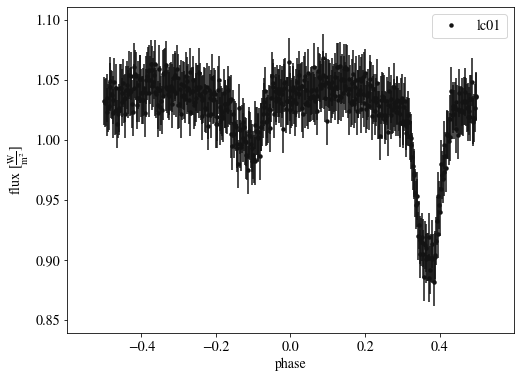

In [6]:
afig, mplfig = b.plot(x='phases',s=0.01,legend=True, edgecolors='none', show=True)

/usr/local/lib/python3.8/dist-packages/phoebe/parameters/parameters.py:9811: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


ParameterSet: 3 parameters
   t0_supconj@binary@orbit@com...: 0.3699414854564364 d
       ecc@binary@orbit@component: 0.05687591927193472
      per0@binary@orbit@component: 299.879469473912 deg


/usr/local/lib/python3.8/dist-packages/phoebe/dependencies/autofig/call.py:1097: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([x, y])
/usr/local/lib/python3.8/dist-packages/phoebe/dependencies/autofig/call.py:1098: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  points = np.array([x, y]).T.reshape(-1, 1, 2)


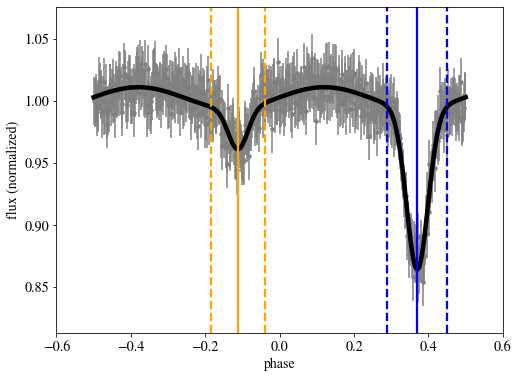

In [7]:
b.add_solver('estimator.lc_geometry', lc='lc01')
b.run_solver(kind='lc_geometry', solution='lc_geom_sol')
print(b.adopt_solution('lc_geom_sol', trial_run=True))
afig, mplfig = b.plot(solution='lc_geom_sol', show = True)

In [8]:
%telepyth 'lc_geom done'

telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'LC Geom Plot')

'lc_geom done'

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: -0.11422845691382788 d
   teffratio@binary@orbit@comp...: 0.9327677912518226
   requivsumfrac@binary@orbit@...: 0.49332103507348674
     esinw@binary@orbit@component: -0.06141966581875491
     ecosw@binary@orbit@component: 0.0014320908764648976
      incl@binary@orbit@component: 70.33792076334275 deg


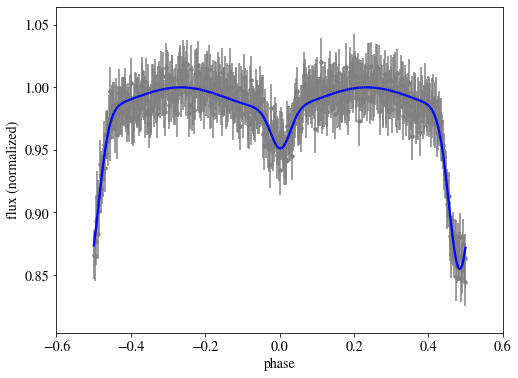

In [9]:
b.add_solver('estimator.ebai', lc='lc01')
b.run_solver(kind='ebai', solution='ebai_sol')
print(b.adopt_solution('ebai_sol', trial_run=True))
afig, mplfig = b.plot(solution='ebai_sol', show=True)

In [10]:
%telepyth 'ebai done'


telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'EBAI plot')

'ebai done'

In [11]:
b.adopt_solution('lc_geom_sol')
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.adopt_solution('ebai_sol', adopt_parameters=['teffratio', 'requivsumfrac', 'incl'])

print(b.filter(qualifier=['ecc', 'per0', 'teff', 'incl'], context='component'))

ParameterSet: 7 parameters
C          teff@primary@component: 6432.469105679228 K
C          incl@primary@component: 70.33792076334275 deg
         teff@secondary@component: 6000.0 K
C        incl@secondary@component: 70.33792076334275 deg
            per0@binary@component: 299.879469473912 deg
             ecc@binary@component: 0.05687591927193472
            incl@binary@component: 70.33792076334275 deg


In [12]:
b.run_compute(irrad_method='none', model='after_estimators', overwrite=True)
%telepyth 'after_estimator computing done'

100%|██████████| 500/500 [00:56<00:00,  8.88it/s]


'after_estimator computing done'

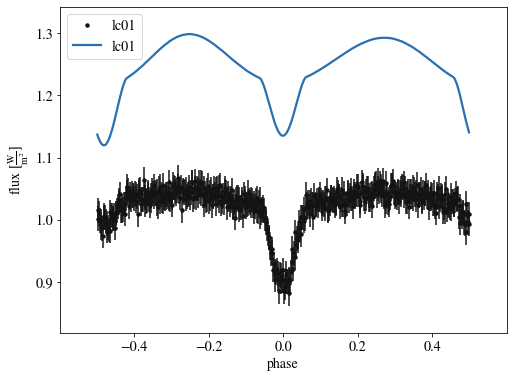

In [13]:
_ = b.plot(x='phases', m='.', legend=True, show=True)

In [14]:
b.add_compute('ellc', compute='fastcompute')

<ParameterSet: 30 parameters | datasets: lc01, _default>

In [15]:
b.set_value_all('pblum_mode', 'dataset-scaled')

b.add_solver('optimizer.nelder_mead', fit_parameters=['teffratio', 'requivsumfrac', 'incl@binary', 'ecc', 'per0'], compute='fastcompute')

<ParameterSet: 12 parameters | qualifiers: adaptive, priors, xatol, fit_parameters, compute, expose_lnlikelihoods, initial_values, maxiter, maxfev, priors_combine, fatol, comments>

In [16]:
print(b.get_solver(kind='nelder_mead'))

ParameterSet: 11 parameters
    comments@nelder_mead01@solver: 
     compute@nelder_mead01@solver: fastcompute
   expose_lnlikelihoods@nelder...: False
   fit_parameters@nelder_mead0...: ['teffratio', 'requivsumfrac', 'incl@binary', 'ecc', 'per0']
   initial_values@nelder_mead0...: {}
      priors@nelder_mead01@solver: []
     maxiter@nelder_mead01@solver: 1000000
      maxfev@nelder_mead01@solver: 1000000
    adaptive@nelder_mead01@solver: False
       xatol@nelder_mead01@solver: 0.0001
       fatol@nelder_mead01@solver: 0.0001


In [17]:
b.run_solver(kind='nelder_mead', maxfev=500, solution='nm_sol')
# maxfev = maximum allowed no. of function evaluations

%telepyth 'Nelder Mead running complete'

  4%|▍         | 40186/1000000 [05:49<1:09:08, 231.36it/s]

'Nelder Mead running complete'

In [18]:
print(b.get_solution('nm_sol').filter(qualifier=['message', 'nfev', 'niter', 'success']))

ParameterSet: 4 parameters
R         message@nm_sol@solution: Maximum number of function evaluations has been exceeded.
R            nfev@nm_sol@solution: 501
R           niter@nm_sol@solution: 284
R         success@nm_sol@solution: False


In [19]:
print(b.adopt_solution('nm_sol', trial_run=True))

ParameterSet: 5 parameters
   teffratio@binary@orbit@comp...: 0.7854004890640227
   requivsumfrac@binary@orbit@...: 0.435883327623098
      incl@binary@orbit@component: 72.23539162636939 deg
       ecc@binary@orbit@component: 0.03836952633738039
      per0@binary@orbit@component: 53.20198063068926 deg


In [20]:
b.adopt_solution('nm_sol')

<ParameterSet: 21 parameters | contexts: component, dataset>

In [21]:
b.run_compute(compute='fastcompute', model='after_nm')
%telepyth 'after_nm computing done'


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


'after_nm computing done'

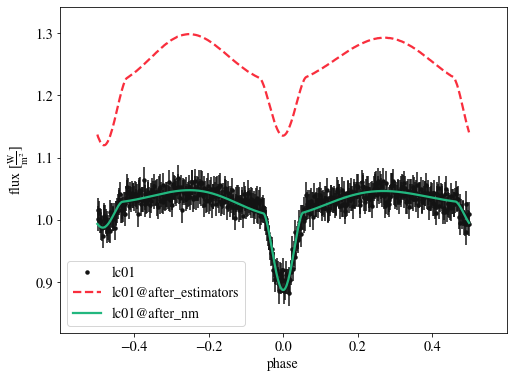

200

In [22]:
afig,mplfig = b.plot(x='phases',
           c={'after_estimators': 'red', 'after_nm': 'green', 'dateset': 'black'},
           linestyle={'after_estimators': 'dashed', 'after_nm': 'solid'},
           marker={'dataset': '.'},
           legend=True,
           show=True)

telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'Estimator Plots')

In [23]:
pblums_scaled = b.compute_pblums(compute='fastcompute', model='after_nm')

print(pblums_scaled)

%telepyth 'pblums_scaled computing done'

{'pblum@primary@lc01': <Quantity 10.45741017 W>, 'pblum@secondary@lc01': <Quantity 2.18888051 W>}


'pblums_scaled computing done'

In [24]:
b.set_value_all('pblum_mode', 'component-coupled')

In [25]:
b.set_value('pblum', dataset='lc01', component='primary', value=pblums_scaled['pblum@primary@lc01'])

print(b.compute_pblums(compute='fastcompute', dataset='lc01', pbflux=True))

%telepyth 'pblums computing done'

  4%|▍         | 40186/1000000 [06:00<1:09:08, 231.36it/s]

{'pblum@primary@lc01': <Quantity 10.45741017 W>, 'pblum@secondary@lc01': <Quantity 2.18888051 W>, 'pbflux@lc01': <Quantity 1.00635984 W / m2>}


'pblums computing done'

In [26]:
b.add_distribution({'teffratio': phoebe.gaussian_around(0.1),
                    'requivsumfrac':phoebe.gaussian_around(0.1),
                    'incl@binary': phoebe.gaussian_around(3),
                    'ecc': phoebe.gaussian_around(0.05),
                    'per0': phoebe.gaussian_around(5),
                    'pblum': phoebe.uniform_around(0.5)},
                    distribution='ball_around_optimized_solution')

<ParameterSet: 6 parameters | components: binary, primary>

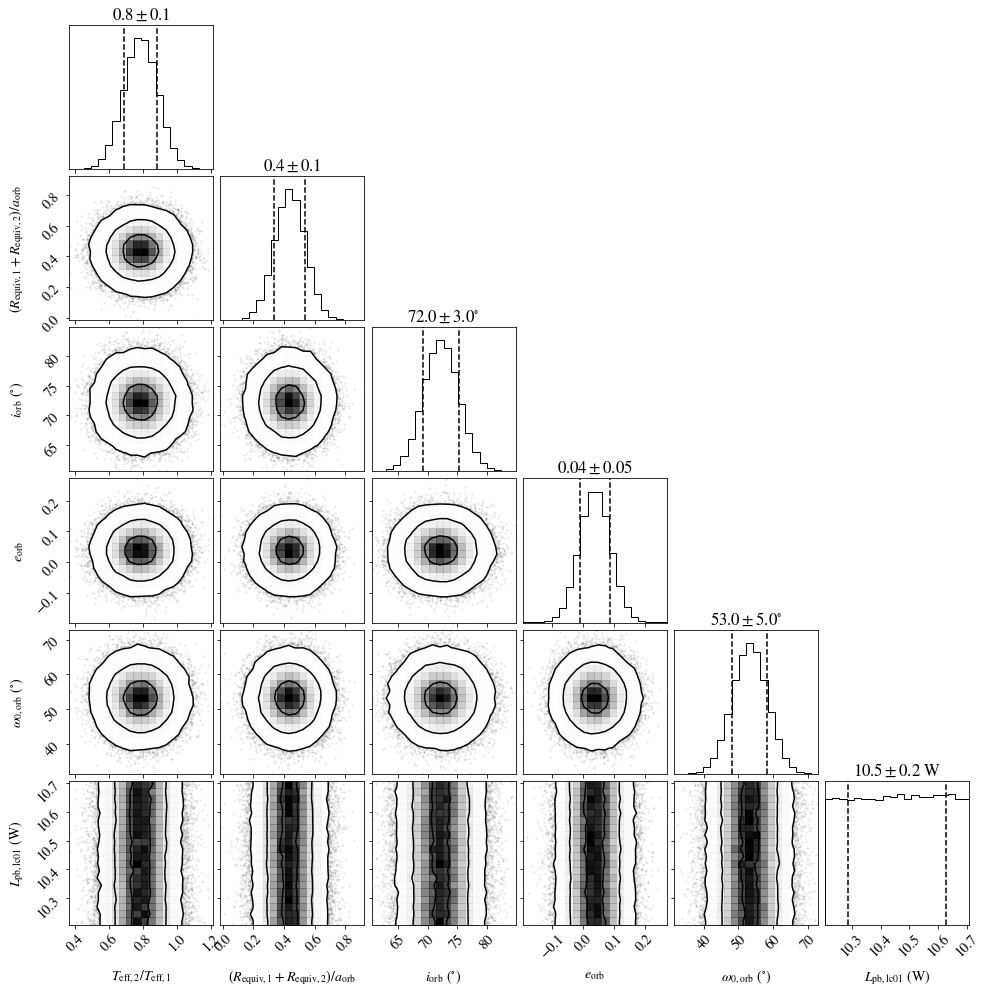

In [27]:
_ = b.plot_distribution_collection('ball_around_optimized_solution', show=True)

In [29]:
b.add_solver('sampler.emcee',
            init_from='ball_around_optimized_solution',
            compute='fastcompute',
            solver='emcee_solver',
            overwrite=True)

b.run_solver('emcee_solver', niters=500, nwalkers=16, log_level='warning', solution='emcee_sol', progress=True, overwrite=True)
%telepyth 'emcee solver running complete'


  0%|          | 0/500 [00:00<?, ?it/s]Wed, 26 Aug 2020 00:14 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while setting the value of 'requiv@primary@star@component'.  Original error: value of requiv=-0.22775826775221508 solRad not within limits of [<Quantity 1.e-06 solRad>, None]

  0%|          | 1/500 [00:04<38:48,  4.67s/it]Wed, 26 Aug 2020 00:14 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while setting the value of 'requiv@primary@star@component'.  Original error: value of requiv=-0.12972971542057798 solRad not within limits of [<Quantity 1.e-06 solRad>, None]

 60%|█████▉    | 298/500 [23:49<15:13,  4.52s/it]


100%|██████████| 500/500 [39:07<00:00,  4.69s/it]


'emcee solver running complete'

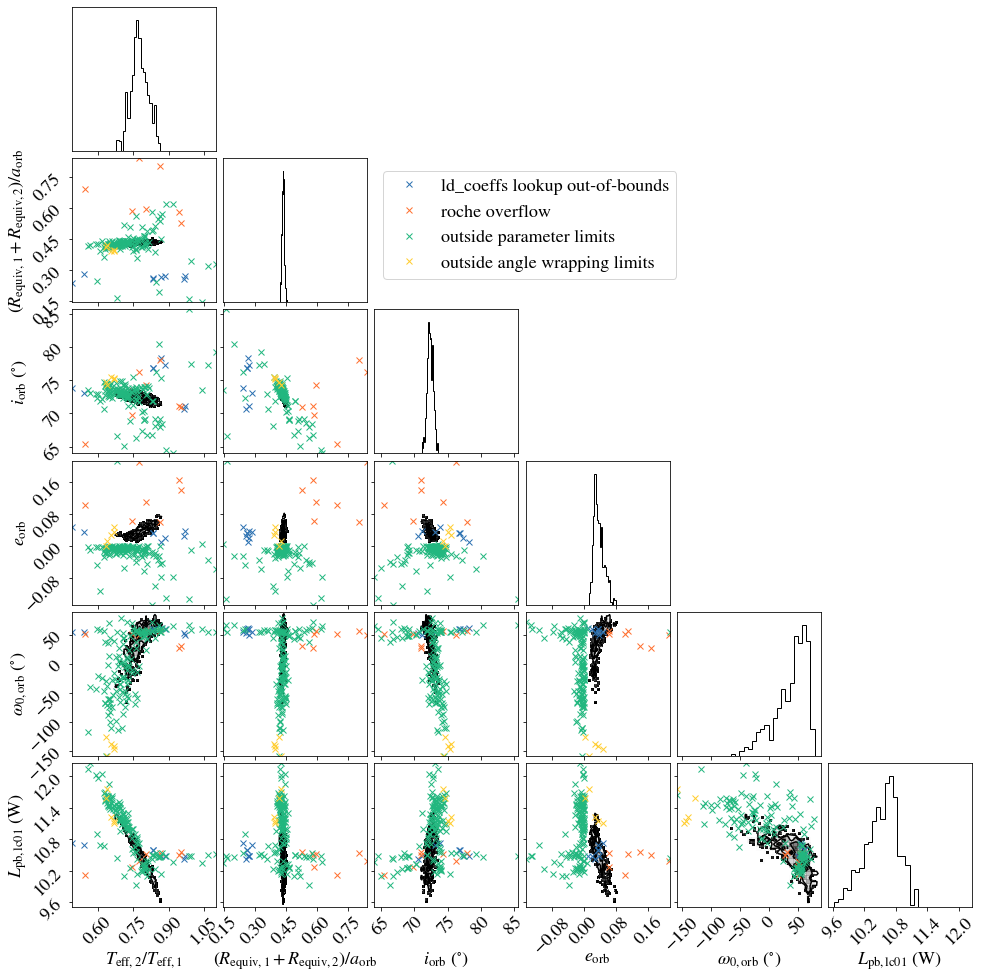

In [30]:
plt.rc('font', size=18)
_ = b.plot('emcee_sol', style='failed', show=True)
plt.rc('font', size=14)

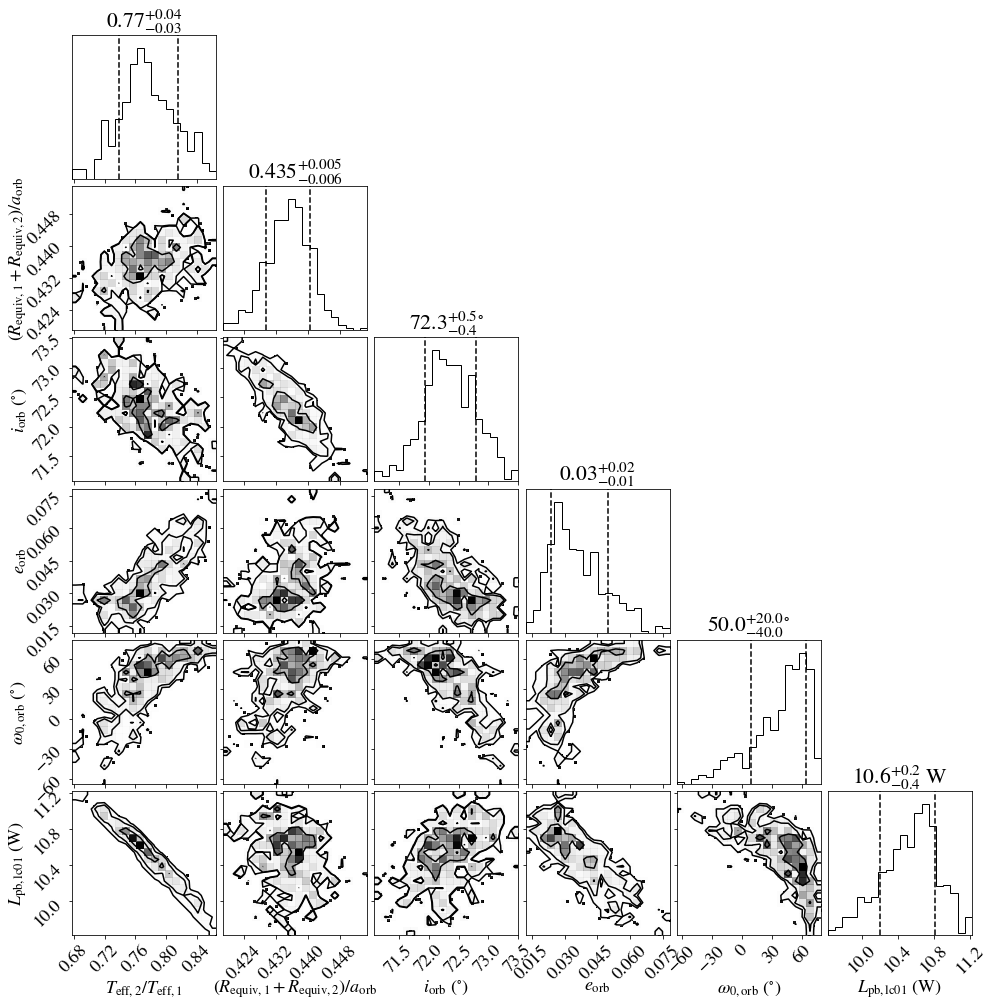

In [31]:
plt.rc('font', size=18)
afig, mplfig = b.plot('emcee_sol', style='corner', show=True)
#%telepyth -t 8276900329739432332
telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig,'Corner Plot')
plt.rc('font', size=14)

In [32]:
%%telepyth 'Values'
b.uncertainties_from_distribution_collection(solution='emcee_sol', tex=True)

'Values'

teffratio@binary = 0.77 +0.04 -0.03  
requivsumfrac@binary = 0.435 +0.005 -0.006  
incl@binary = 72.3 +0.5 -0.4  deg
ecc@binary = 0.03 +0.02 -0.01  
per0@binary = 50.0 +20.0 -40.0  deg
pblum@lc01 = 10.6 +0.2 -0.4  W

In [33]:
b.run_compute(compute='fastcompute', sample_from='emcee_sol', sample_num=500, sample_mode='3-sigma', model='emcee_posts', overwrite=True)
%telepyth 'emcee_posts comuting done'


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

100%|██████████| 1/1 [00:00<00:00, 15.62it/s]

100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

100%|██████████| 1/1 [00:00<00:00, 15.27it/s]

100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

100%|██████████| 1/1 [00:00<00:00, 15.74it/s]

100%|██████████| 1/1 [00:00<00:00, 15.71it/s]

100%|██████████| 1/1 [00:00<00:00, 15.37it/s]

100%|██████████| 1/1 [00:00<00:00, 14.75it/s]

100%|██████████| 1/1 [00:00<00:00, 15.63it/s]

100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

100%|██████████| 1/1 [00:00<00:00, 15.69it/s]

100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

100%|██████████| 1/1 [00:00<00:00, 14.17it/s]

100%|██████████| 1/1 [00:00<00:00, 15.16it/s]

100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

100%|███████

100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

100%|██████████| 1/1 [00:00<00:00, 15.54it/s]

100%|██████████| 1/1 [00:00<00:00, 14.82it/s]

100%|██████████| 1/1 [00:00<00:00, 13.41it/s]

100%|██████████| 1/1 [00:00<00:00, 14.74it/s]

100%|██████████| 1/1 [00:00<00:00, 13.61it/s]

100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

100%|██████████| 1/1 [00:00<00:00, 15.39it/s]

100%|██████████| 1/1 [00:00<00:00, 15.19it/s]

100%|██████████| 1/1 [00:00<00:00, 14.22it/s]

100%|██████████| 1/1 [00:00<00:00, 13.06it/s]

100%|██████████| 1/1 [00:00<00:00, 15.60it/s]

100%|██████████| 1/1 [00:00<00:00, 14.23it/s]

100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

100%|██████████| 1/1 [00:00<00:00, 15.17it/s]

100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

100%|██████████| 1/1 [00:00<00:00, 12.90it/s]

100%|██████████| 1/1 [00:00<00:00, 14.90it/s]

100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

100%|████████

'emcee_posts comuting done'

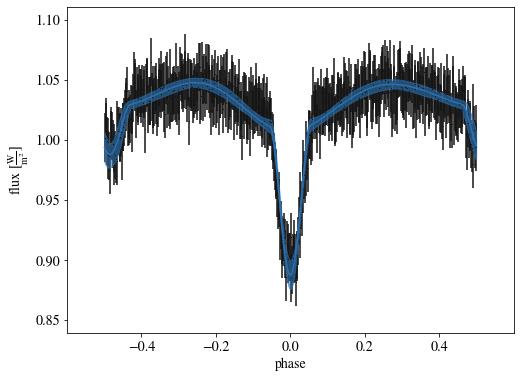

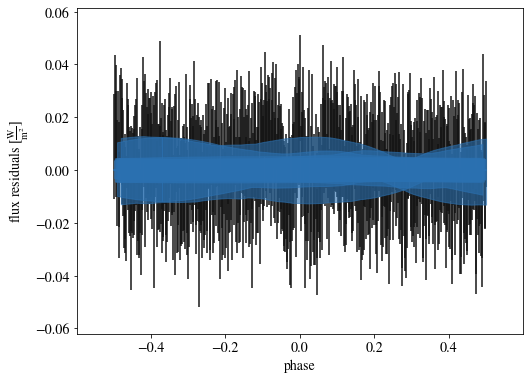

200

In [35]:
afig4,mplfig4 = b.plot(kind='lc', model='emcee_posts', x='phases', y='fluxes', s={'dataset': 0.005}, marker={'dataset': '.'}, show=True)
afig5,mplfig5 = b.plot(kind='lc', model='emcee_posts', x='phases', y='residuals', z={'dataset': 0, 'model': 1}, show=True)

telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig4,'LC Plot')
telepyth.TelepythClient(token='8276900329739432332').send_figure(mplfig5,'LC residual Plot')